In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")


In [45]:
# Dataset Path
dataset_path = os.path.dirname(os.path.abspath('dataset'))
output_path = os.path.join(dataset_path, "plots")
os.makedirs(output_path, exist_ok=True)


In [51]:
# 1. Load Data
def load_data(dataset_path="dataset"):
    train_path = os.path.join(dataset_path, "train.csv")
    store_path = os.path.join(dataset_path, "store.csv")
    
    # Check file existence
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Train file not found at {train_path}")
    if not os.path.exists(store_path):
        raise FileNotFoundError(f"Store file not found at {store_path}")

    # Load data
    train_df = pd.read_csv(train_path, parse_dates=["Date"])
    store_df = pd.read_csv(store_path)

    print(f"✅ Loaded: Train shape = {train_df.shape}, Store shape = {store_df.shape}")
    
    return train_df, store_df

# Load both dataframes
train_df, store_df = load_data()

✅ Loaded: Train shape = (1017209, 9), Store shape = (1115, 10)


In [52]:
# 2. Preprocess Data
def preprocess_data(train_df, store_df):
    df = pd.merge(train_df, store_df, how="left", on="Store")
    df = df[df["Sales"] > 0]
    df["Date"] = pd.to_datetime(df["Date"])
    df["Month"] = df["Date"].dt.month
    df["Year"] = df["Date"].dt.year
    df["DayOfWeek"] = df["Date"].dt.dayofweek

    df["PromoInterval"].fillna("", inplace=True)
    month_str_to_num = {
        "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
        "Jul": 7, "Aug": 8, "Sept": 9, "Oct": 10, "Nov": 11, "Dec": 12
    }

    def promo2_active(row):
        if row["Promo2"] == 0 or row["PromoInterval"] == "":
            return 0
        months = [month_str_to_num.get(m.strip()[:3], 0) for m in row["PromoInterval"].split(",")]
        return 1 if row["Month"] in months else 0

    df["Promo2Active"] = df.apply(promo2_active, axis=1)
    df["StateHoliday"] = df["StateHoliday"].replace({0: '0', '0': '0'})
    df["IsStateHoliday"] = df["StateHoliday"].apply(lambda x: 0 if x == '0' else 1)
    return df

df = preprocess_data(train_df, store_df)

In [53]:

# 3. Add Holidays
def add_holidays():
    holidays = pd.DataFrame({
        "holiday": ["Christmas", "NewYear", "Easter", "NationalDay"],
        "ds": pd.to_datetime(["2014-12-25", "2015-01-01", "2015-04-05", "2015-10-03"]),
        "lower_window": 0,
        "upper_window": 1
    })
    return holidays

holidays_df = add_holidays()

In [54]:
# 4. Forecast Model
def train_model(df, holidays_df):
    sales_df = df.groupby("Date")["Sales"].sum().reset_index()
    sales_df.columns = ["ds", "y"]

    model = Prophet(holidays=holidays_df, yearly_seasonality=True, weekly_seasonality=True)
    model.fit(sales_df)

    future = model.make_future_dataframe(periods=60)
    forecast = model.predict(future)

    return model, forecast

model, forecast = train_model(df, holidays_df)

12:17:33 - cmdstanpy - INFO - Chain [1] start processing
12:17:33 - cmdstanpy - INFO - Chain [1] done processing


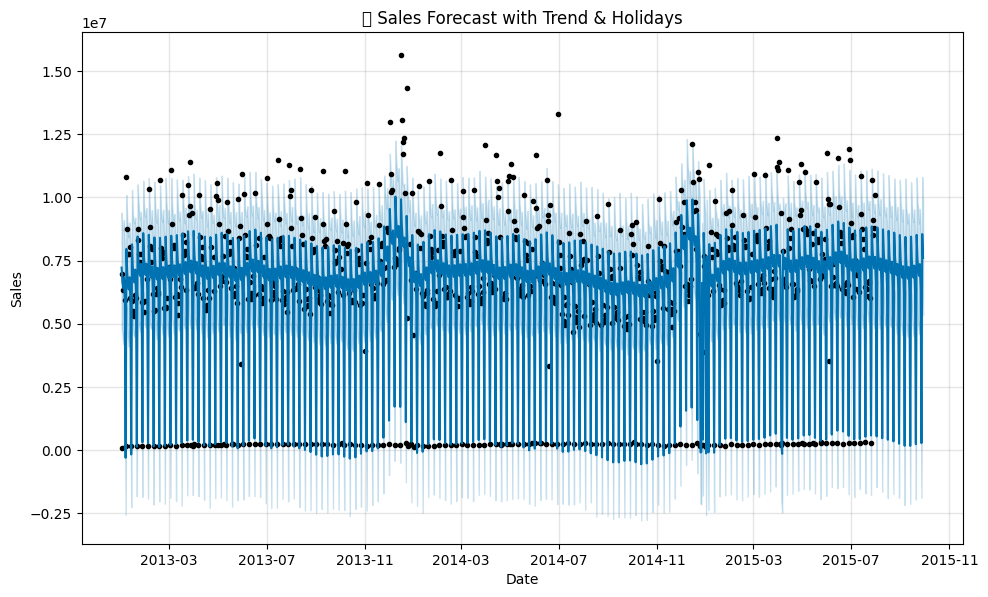

In [55]:
# 📊 Plot 1: Forecast with Trend & Holidays
def plot_forecast(model, forecast):
    fig = model.plot(forecast)
    plt.title("📈 Sales Forecast with Trend & Holidays")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    fig.savefig(os.path.join(output_path, "forecast_trend.png"))
    plt.show()

plot_forecast(model, forecast)


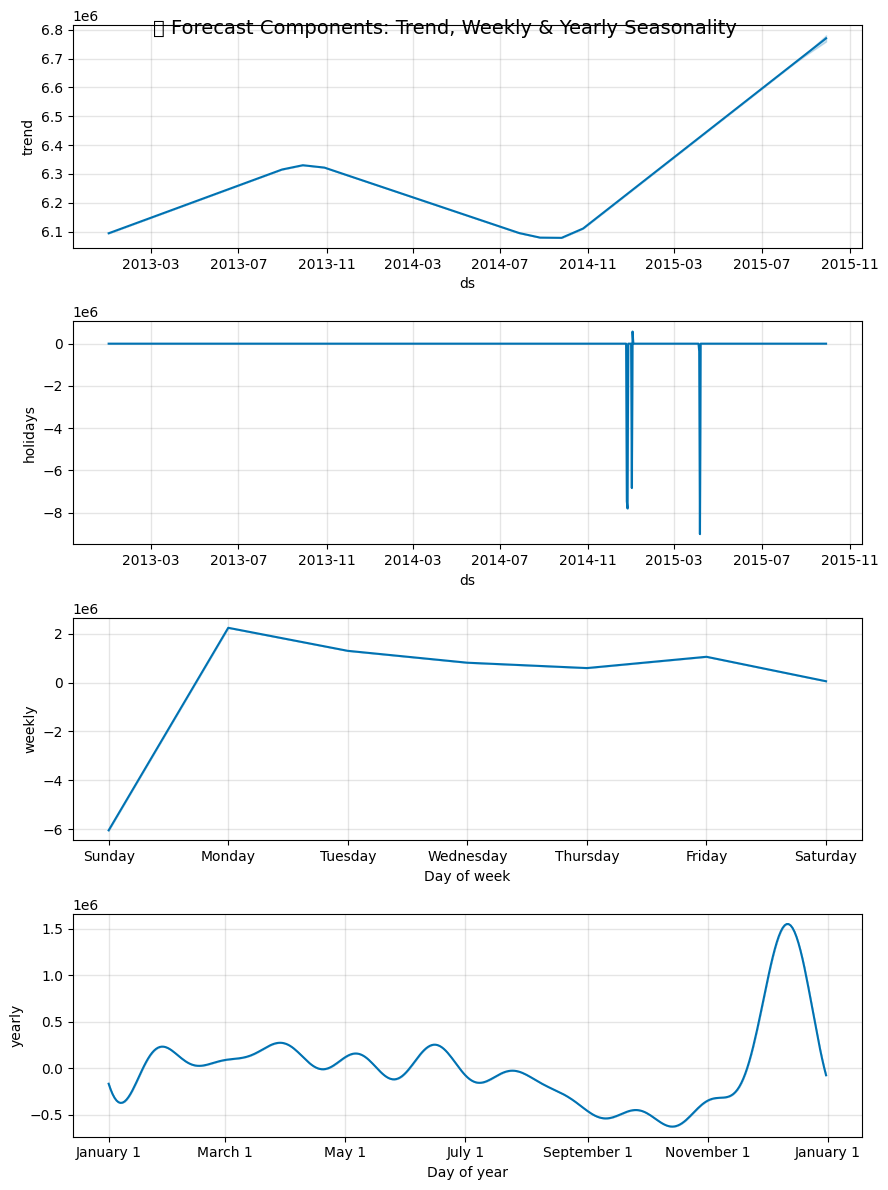

In [56]:
# 📊 Plot 2: Forecast Components
def plot_components(model, forecast):
    fig = model.plot_components(forecast)
    fig.suptitle("🔍 Forecast Components: Trend, Weekly & Yearly Seasonality", fontsize=14)
    fig.savefig(os.path.join(output_path, "forecast_components.png"))
    plt.show()

plot_components(model, forecast)

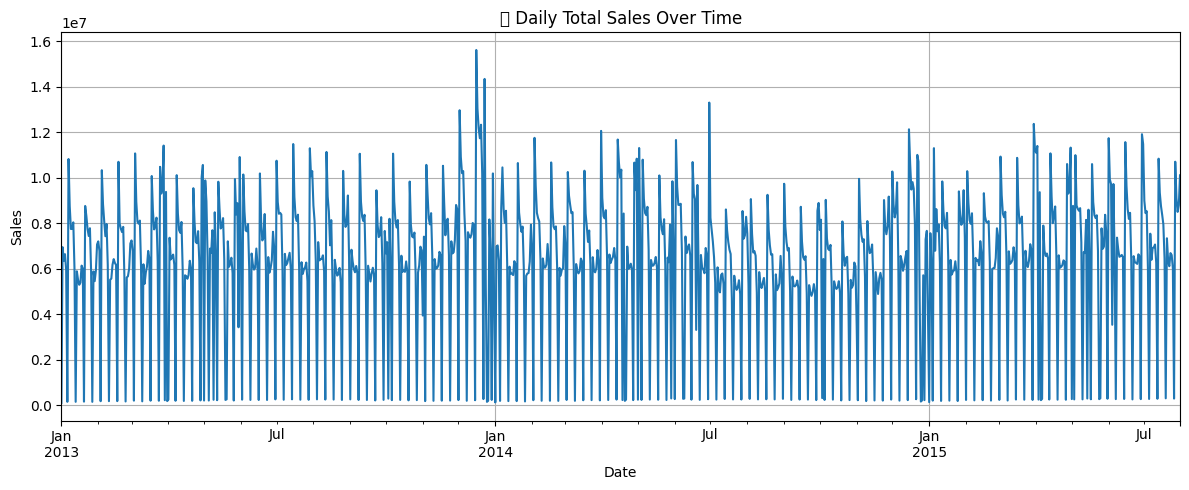

In [57]:
# 📊 Plot 3: Daily Sales Over Time
def plot_daily_sales(df):
    plt.figure(figsize=(12, 5))
    df.groupby("Date")["Sales"].sum().plot()
    plt.title("🕒 Daily Total Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "daily_sales_trend.png"))
    plt.show()

plot_daily_sales(df)

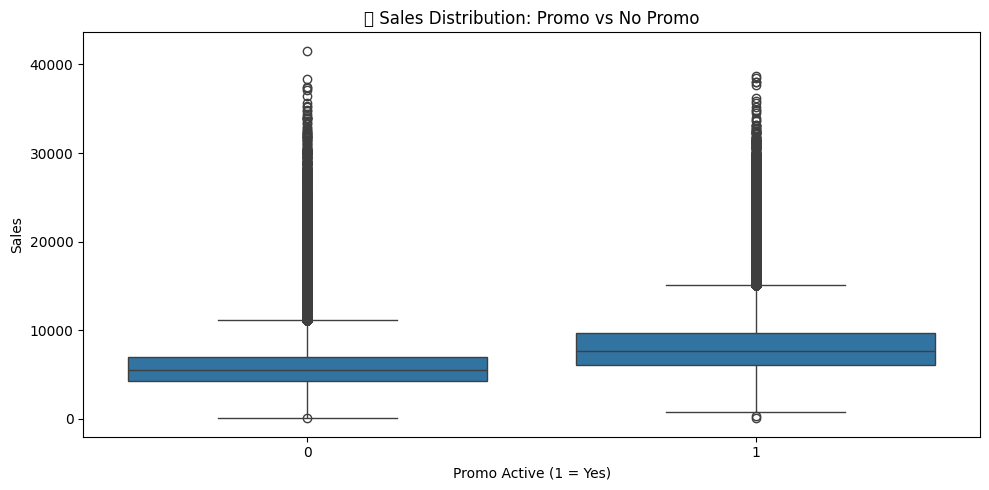

In [58]:
# 📊 Plot 4: Promo Impact on Sales
def plot_sales_promo(df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="Promo", y="Sales", data=df)
    plt.title("📦 Sales Distribution: Promo vs No Promo")
    plt.xlabel("Promo Active (1 = Yes)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "promo_sales_impact.png"))
    plt.show()

plot_sales_promo(df)

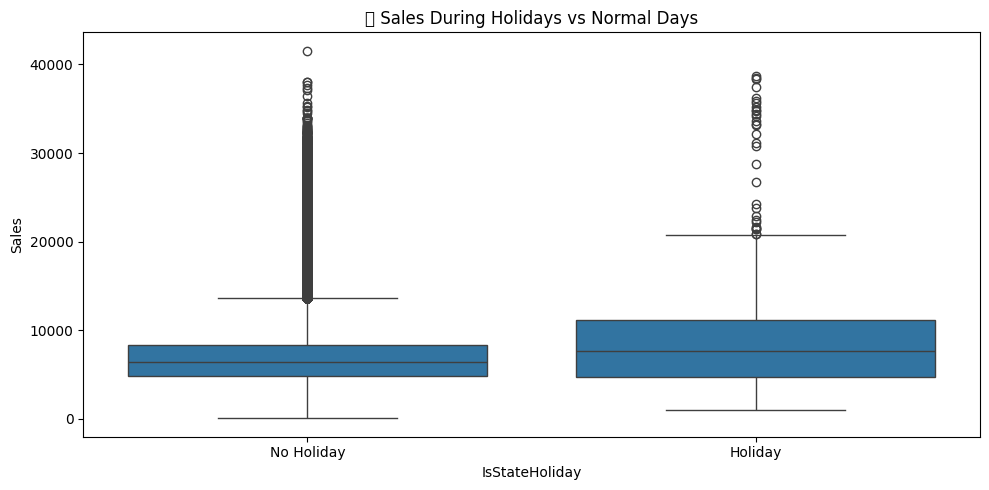

In [59]:

# 📊 Plot 5: Holiday Impact on Sales
def plot_holiday_impact(df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="IsStateHoliday", y="Sales", data=df)
    plt.title("🎉 Sales During Holidays vs Normal Days")
    plt.xticks([0, 1], ["No Holiday", "Holiday"])
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "holiday_sales_impact.png"))
    plt.show()

plot_holiday_impact(df)

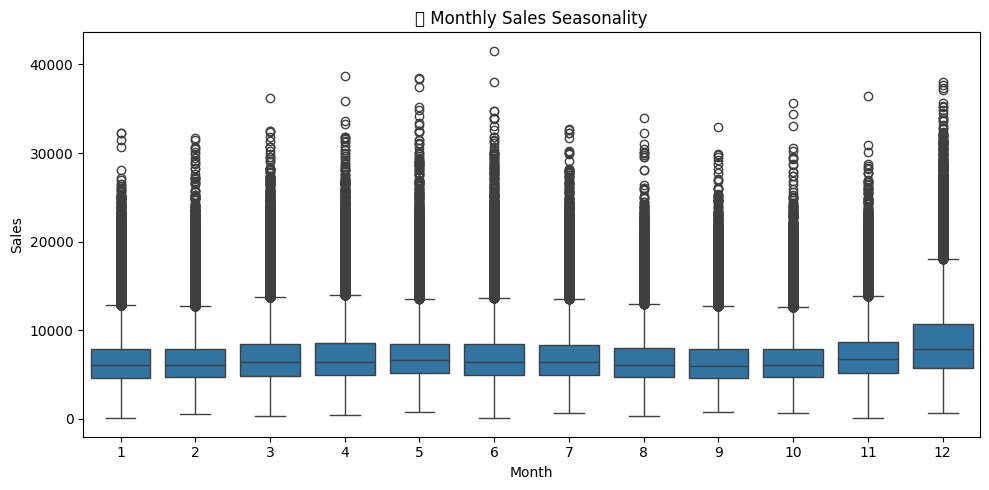

In [60]:
# 📊 Plot 6: Monthly Sales Seasonality
def plot_monthly_seasonality(df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="Month", y="Sales", data=df)
    plt.title("📅 Monthly Sales Seasonality")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "monthly_sales_seasonality.png"))
    plt.show()

plot_monthly_seasonality(df)

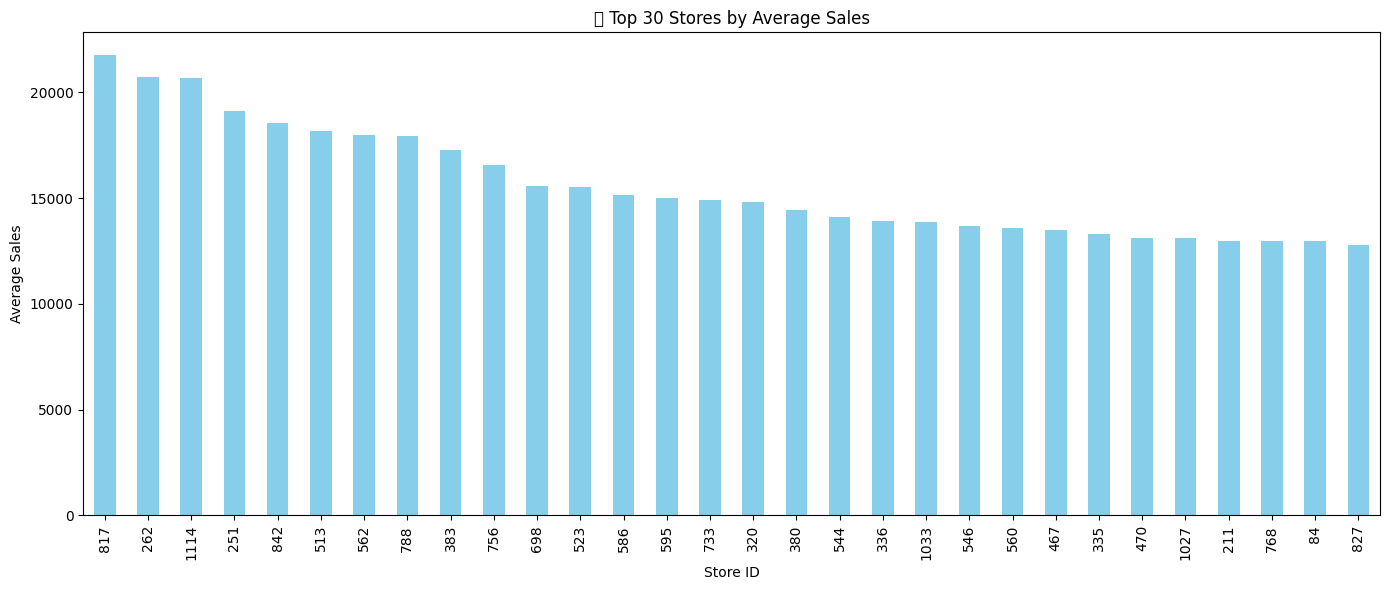

In [61]:
# 📊 Plot 7: Top 30 Stores by Average Sales
def plot_top_stores(df):
    plt.figure(figsize=(14, 6))
    avg_sales = df.groupby("Store")["Sales"].mean().sort_values(ascending=False)[:30]
    avg_sales.plot(kind="bar", color="skyblue")
    plt.title("🏪 Top 30 Stores by Average Sales")
    plt.xlabel("Store ID")
    plt.ylabel("Average Sales")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "top_30_stores_avg_sales.png"))
    plt.show()

plot_top_stores(df)